## Load data for all pyramidal cells from all trials into a dataframe of ephys objects

In [2]:
import numpy as np
import pandas as pd
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from session_utils import *
from ephys import *
from ephys_utils import select_spikes_by_trial

lfp_sampling_rate = 1000

# Load all session names and paths as dict
session_list = find_all_sessions(sheet_path = 'https://docs.google.com/spreadsheets/d/1_Xs5i-rHNTywV-WuQ8-TZliSjTxQCCqGWOD2AL_LIq0/edit#gid=0',
                                 data_path = '/home/isabella/Documents/isabella/jake/recording_data',
                                 sorting_suffix = 'sorting_ks2_custom')

# Initialise DataFrame and explicitly set dtype for 'clusters_inc' to 'object'
df_all_cells = pd.DataFrame(data = None, index = session_list.keys(), columns=['clusters_inc'], dtype='object')


for i, session_path in enumerate(session_list.values()):
    session = list(session_list.keys())[i]
    
    # Get IDs of included clusters from postprocessing.Select Clusters All Sessions.ipynb
    clusters_inc = np.load(f'{session_path}/clusters_inc.npy', allow_pickle = True)
    
    if len(clusters_inc) > 0:
        df_all_cells.at[session, 'clusters_inc'] = clusters_inc

        # Create ephys object for session and add to dataframe
        obj = ephys(recording_type = 'nexus', path = session_path)

        # Load spikes for all included clusters
        obj.load_spikes(clusters_inc)
        
        # Reorganise spikes by trial, starting at t=0 at each trial
        obj.spikes_by_trial = select_spikes_by_trial(obj.spike_data, obj.trial_iterators, obj.trial_offsets)

        # Load position data for all trials
        obj.load_pos(obj.trial_iterators, output_flag = False, reload_flag = False)

        # Get unique channels with included cells
        obj.good_channels = np.unique(obj.spike_data['cluster_info'].loc(axis=1)['ch'])
        
        # # Load LFP for all trials for channels with units
        # obj.load_lfp(obj.trial_iterators, lfp_sampling_rate, channels = obj.good_channels, reload_flag = True)

        # Add data to frame
        df_all_cells.at[list(session_list.keys())[i], 'ephys_object'] = obj

    print(f'Loaded session {session}')

# Pickle dataframe for loading elsewhere
df_all_cells.to_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/df_all_cells.pkl')
print(f'All data saved to /home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/df_all_cells.pkl')

df_all_cells.head()

Loaded session 230503_r1354
Loaded session 230504_r1354
Loaded session 230505_r1354


/data/isabella/jake/ephys_analysis/pyScan/analysis/../postprocessing/postprocess_pos_data.py:219: RuntimeWarning: invalid value encountered in remainder
  dir_disp = np.mod(np.arctan2(-pos.iloc[1, 1:].values + pos.iloc[1, :-1].values, pos.iloc[0, 1:].values - pos.iloc[0, :-1].values) * 180 / np.pi, 360)


Loaded session 230506_r1354
Loaded session 230507_r1354
Loaded session 230508_r1354
Loaded session 230509_r1354
Loaded session 230510_r1354
Loaded session 230607_r1364
Loaded session 230608_r1364
Loaded session 230609_r1364
Loaded session 230610_r1364
Loaded session 230611_r1364
Loaded session 230612_r1364
Loaded session 230613_r1364
Loaded session 230614_r1364
Loaded session 230615_r1364
Loaded session 230616_r1364
Loaded session 230617_r1364
Loaded session 230618_r1364
Loaded session 230619_r1364
Loaded session 230729_r1398
Loaded session 230729_r1399
Loaded session 230730_r1398
Loaded session 230730_r1399
Loaded session 230731_r1398
Loaded session 230731_r1399
Loaded session 230801_r1398
Loaded session 230801_r1399
Loaded session 230802_r1398
Loaded session 230802_r1399
Loaded session 230803_r1398
Loaded session 230803_r1399
Loaded session 230804_r1398
Loaded session 230805_r1398
Loaded session 230806_r1398
Loaded session 230807_r1398
Loaded session 230808_r1398
Loaded session 23080

,clusters_inc,ephys_object
230503_r1354,NaN,NaN
230504_r1354,NaN,NaN
230505_r1354,NaN,NaN
230506_r1354,"[236, 247, 251, 260, 264, 281, 308, 322]",<ephys.ephys object at 0x7fd0195f5f50>
230507_r1354,"[37, 215, 248, 326, 371, 388]",<ephys.ephys object at 0x7fcf8b01cc90>


## Calculate theta phase for all pyramidal cells

In [2]:
import numpy as np
import pandas as pd
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from position_analysis import *
from get_theta_frequencies import get_theta_frequencies
from get_theta_phase import get_spike_theta_phase
from ephys import *
from postprocessing.spatial_analysis import speed_filter_spikes
from rayleigh_vector import rayleigh_vector


In [ ]:

# Load pickled data
df_all_cells = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/df_all_cells.pkl')

lfp_sampling_rate = 1000

# Drop rows with no included clusters
df_all_cells = df_all_cells.dropna()
print(f'{len(df_all_cells.index)} sessions retained')

# Loop through all sessions
for index, obj in df_all_cells['ephys_object'].items():
    
    # # Find t-maze and open field trials for session
    # t_maze_trials = [i for i, s in enumerate(obj.trial_list) if 't-maze' in s]
    # open_field_trials = [i for i, s in enumerate(obj.trial_list) if 'open-field' in s]
    
    # Initialise output variables
    obj.cluster_phases = [{} for _ in range(len(obj.trial_list))]
    obj.cluster_sectors = [{} for _ in range(len(obj.trial_list))]
    obj.cluster_rayleigh = [{} for _ in range(len(obj.trial_list))]
    
    # Load LFP if not already loaded
    obj.load_lfp(obj.trial_iterators, lfp_sampling_rate, channels = obj.good_channels, reload_flag = False)

    # Load LFP and position for each channel, get theta phase and position sector for each spike
    for i in obj.trial_iterators:
        
        # Extract XY position data for trial
        trial_pos = obj.pos_data[i]['xy_position']

        # Convert to DataFrame and rename columns to match original channel
        lfp_df = pd.DataFrame(obj.lfp_data[i]['data'])
        lfp_df.columns = obj.good_channels

        # Find peak theta frequencies for each channel and make dict of {channel: theta_freq}
        theta_freqs = get_theta_frequencies(obj.lfp_data[i]['data'], lfp_sampling_rate)
        theta_freqs = dict(zip(obj.good_channels, theta_freqs))


        # Loop through each good cluster
        for cluster in obj.spike_data['cluster_info'].index:
            # Get channel for cluster
            channel = obj.spike_data['cluster_info'].loc[cluster, 'ch']

            # Get peak theta frequency
            theta_freq = theta_freqs[channel]

            ## SPIKE PHASE
            # Extract LFP data for the recording channel
            lfp_data_for_channel = lfp_df.loc[:, channel]

            # Extract spike times for the cluster
            cluster_spike_times = obj.spikes_by_trial[i]['spike_times'][obj.spikes_by_trial[i]['spike_clusters'] == cluster]
            
            # Filter for speed (function from spatial_analysis.py)
            spike_times_filtered = speed_filter_spikes(current_trial_spikes = {cluster: cluster_spike_times}, #Needs to be dict, key not important
                                                        speed_data = obj.pos_data[i]['speed'],
                                                        position_sampling_rate = obj.pos_data[i]['pos_sampling_rate'],
                                                        speed_lower_bound = 10, #2.5 cm/s
                                                        speed_upper_bound = 400) #100 cm/s

            # Compute theta phases for the spike times
            spike_phases = get_spike_theta_phase(lfp_data_for_channel, spike_times_filtered[cluster], lfp_sampling_rate, theta_freq)

            # Store in the dictionary
            obj.cluster_phases[i][cluster] = spike_phases    

            ## SPIKE POSITION SECTOR
            # Assign spike times to nearest position sector
            spike_pos = [[], []]
            for t in spike_times_filtered[cluster]:
                spike_pos_index = round(t * 50)/50
                spike_pos[0].append(trial_pos[spike_pos_index].values[0])
                spike_pos[1].append(trial_pos[spike_pos_index].values[1])

            # spike_pos is now an array with the structure  [[x1, x2, x3 ...], [y1, y2, y3 ...]] for each spike
            # Get position sector for each spike
            spike_sectors = assign_sectors(pd.DataFrame(spike_pos), pos_header = obj.pos_data[i]['header'])

            # add sectors to dict
            obj.cluster_sectors[i][cluster] = spike_sectors

            ## RAYLEIGH VECTOR
            # Compute rayleigh vector for each cluster
            obj.cluster_rayleigh[i][cluster] = rayleigh_vector(spike_phases)
    
    
    # Re-assign object to dataframe
    df_all_cells.loc[index, 'ephys_object'] = obj
    print(f'Session {index} processed')

# Pickle dataframe for loading elsewhere
df_all_cells.to_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/df_all_cells_theta.pkl')

## Plot Rayleigh Vector Distribution by Age Bin

In [40]:
import matplotlib.pyplot as plt 
# Set age bins
age_bins = [(22, 26), (27, 29), (30, 35)]

# Load pickled data with theta phase
df_all_cells = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/df_all_cells_theta.pkl')

# Drop rows with no included clusters
df_all_cells = df_all_cells.dropna()
print(f'{len(df_all_cells.index)} sessions retained')

# Initialise dataframe for storing rayleigh vector info
df_rayleigh = pd.DataFrame(data = None, index = None, columns = ['animal', 'age', 'date', 'trial_type', 'session', 'rayleigh_vector_length', 'rayleigh_vector_angle'])

# Loop through all sessions
for index, obj in df_all_cells['ephys_object'].items():

    # Get rayleigh vector info for each cluster
    rayleigh_info = obj.cluster_rayleigh

    # Get age and animal ID
    age = int(obj.age)
    animal = obj.animal
    date = obj.date_short
    session = obj.sorting_path

    # Loop through each trial
    for trial_iterator, trial in enumerate(obj.trial_list):
        # Get rayleigh vector info for each cluster
        rayleigh_info = obj.cluster_rayleigh[trial_iterator]

        # Loop through each cluster
        for cluster in rayleigh_info.keys():
            # Get rayleigh vector info for cluster
            vector_length = rayleigh_info[cluster][0]
            vector_angle = rayleigh_info[cluster][1]

            # Get trial type
            if 't-maze' in trial:
                trial_type = 't-maze'
            elif 'open-field' in trial:
                trial_type = 'open-field'
            else:
                trial_type = 'other'
            
            # Add to dataframe with trial name as index
            df_rayleigh.loc[f'{trial}_{cluster}', :] = [animal, age, date, trial_type, session, vector_length, vector_angle]

df_rayleigh

29 sessions retained


,animal,age,date,trial_type,session,rayleigh_vector_length,rayleigh_vector_angle
230506_r1354_raw_open-field_1_236,r1354,26,230506,open-field,/home/isabella/Documents/isabella/jake/recordi...,0.133417,2.701345
230506_r1354_raw_open-field_1_247,r1354,26,230506,open-field,/home/isabella/Documents/isabella/jake/recordi...,0.102817,-2.678617
230506_r1354_raw_open-field_1_251,r1354,26,230506,open-field,/home/isabella/Documents/isabella/jake/recordi...,0.178211,-2.893424
230506_r1354_raw_open-field_1_260,r1354,26,230506,open-field,/home/isabella/Documents/isabella/jake/recordi...,0.198491,2.346045
230506_r1354_raw_open-field_1_264,r1354,26,230506,open-field,/home/isabella/Documents/isabella/jake/recordi...,0.198561,-2.972486
...,...,...,...,...,...,...,...
231101_r1428_raw_open-field_2_285,r1428,34,231101,open-field,/home/isabella/Documents/isabella/jake/recordi...,0.143074,2.245615
231101_r1428_raw_open-field_2_301,r1428,34,231101,open-field,/home/isabella/Documents/isabella/jake/recordi...,0.204279,2.088806
231101_r1428_raw_t-maze_2_283,r1428,34,231101,t-maze,/home/isabella/Documents/isabella/jake/recordi...,0.052477,2.870996
231101_r1428_raw_t-maze_2_285,r1428,34,231101,t-maze,/home/isabella/Documents/isabella/jake/recordi...,0.157837,2.432841


/tmp/ipykernel_13886/3283738733.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[i, j] = plt.subplot(3, 2, 2*i + j + 1, projection = 'polar')


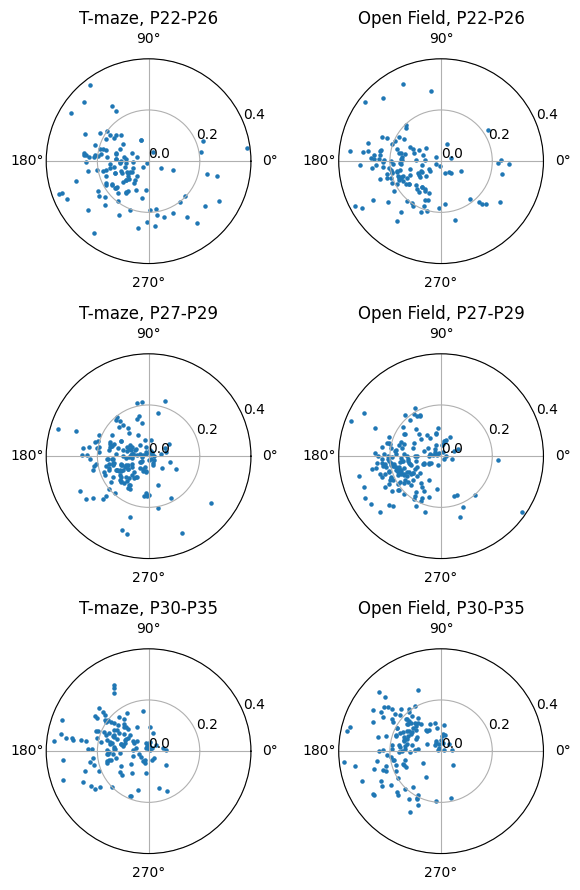

In [20]:
# Plot rayleigh vector length and angle for each cluster, binned by age and trial type
fig, ax = plt.subplots(3, 2, figsize = (6, 9))
for i, age_bin in enumerate(age_bins):
    for j, trial_type in enumerate(['t-maze', 'open-field']):
        # Get data for age bin and trial type
        data = df_rayleigh.loc[(df_rayleigh['age'] >= age_bin[0]) & (df_rayleigh['age'] <= age_bin[1]) & (df_rayleigh['trial_type'] == trial_type), :]

        # Set subplot as polar
        ax[i, j] = plt.subplot(3, 2, 2*i + j + 1, projection = 'polar')
        # Plot length and angle
        ax[i, j].scatter(data['rayleigh_vector_angle'], data['rayleigh_vector_length'], s = 5)
        if trial_type == 't-maze':
            label = 'T-maze'
        elif trial_type == 'open-field':
            label = 'Open Field'
        ax[i, j].set_title(f'{label}, P{age_bin[0]}-P{age_bin[1]}')
        ax[i, j].set_rticks([0, 0.2, 0.4])
        ax[i, j].set_rlim([0, 0.4])
        ax[i, j].set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
        # ax[i, j].set_xticklabels(['0', 'π/2', 'π', '3π/2'])
plt.tight_layout()

In [57]:
df_rayleigh['cell'] = df_rayleigh.index.str.split('_').str[5]
# Combine date, animal, and cell ID into unique cell ID
df_rayleigh['unique_cell'] = df_rayleigh['date'] + '_' + df_rayleigh['animal'] + '_' + df_rayleigh['cell']

# Calculate difference in rayleigh vector angle between t-maze and open field trials for each cluster
mean_vector_data_trial_type = df_rayleigh.groupby(['unique_cell','trial_type'])[['rayleigh_vector_length', 'rayleigh_vector_angle']].mean()
mean_vector_data_trial_type

# Calculate difference in rayleigh vector angle between t-maze and open field trials for each unique cell


rayleigh_vector_length rayleigh_vector_angle
unique_cell      trial_type                                             
230506_r1354_236 open-field               0.126441              2.714078
                 t-maze                   0.088271              1.930922
230506_r1354_247 open-field               0.132612             -2.806683
                 t-maze                   0.089523              2.904538
230506_r1354_251 open-field               0.168673             -2.991413
...                                            ...                   ...
231101_r1428_283 t-maze                   0.034294              1.821337
231101_r1428_285 open-field                0.15149              2.316802
                 t-maze                   0.143134              2.381399
231101_r1428_301 open-field               0.231036              2.012142
                 t-maze                   0.272873              2.093345

[444 rows x 2 columns]

## Plot theta phase vs position sector for t-maze and theta phase for open field

In [ ]:
# Plotting functions
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import scipy.stats

# Function to get phases for a given sector within a specific cluster
def get_phases_for_sector_in_cluster(cluster_sectors, cluster_phases, sector, cluster_id):
    indices = np.where(cluster_sectors[int(cluster_id)] == sector)[0]
    return cluster_phases[int(cluster_id)][indices]

# Function to plot polar plots for a specific cluster
def plot_theta_phase_by_position_cluster(obj, trial_iterator, cluster_id, session):
    
    # Define the directory where you want to save the figure
    save_directory = f'/home/isabella/Documents/isabella/jake/ephys_analysis/figures/P{obj.age}_{session}'
    
    # Check if the directory exists, if not, create it
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
        
    ### For T-MAZE TRIALS:
    if 't-maze' in obj.trial_list[trial_iterator]:
        unique_sectors = range(1,13)
        fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10), subplot_kw={'projection': 'polar'})

        for idx, sector in enumerate(unique_sectors):
            row_idx = idx // 4
            col_idx = idx % 4
            sector = int(sector)

            phases = get_phases_for_sector_in_cluster(obj.cluster_sectors[trial_iterator], obj.cluster_phases[trial_iterator], sector, cluster_id)

            # Remove any NaN/ infinite values
            phases = phases[np.isfinite(phases)]

            # Calculate circular mean of theta phase
            mean_phase = scipy.stats.circmean(phases, nan_policy = 'omit')
            std_phase = scipy.stats.circstd(phases, nan_policy = 'omit')

            # Histogram of the phases
            n, bins, patches = axes[row_idx, col_idx].hist(phases, bins=30, alpha=0.6)

            # Add a red line indicating the mean phase
            axes[row_idx, col_idx].axvline(mean_phase, color='r', linestyle='--', linewidth=2)

            # Add a sector indicating standard deviation
            # axes[row_idx, col_idx].axvspan(mean_phase-std_phase, mean_phase+std_phase, color='r', alpha = 0.4)

            # Set the title for the current subplot
            axes[row_idx, col_idx].set_title(f"Sector {sector}")

        plt.suptitle(f'Theta phase vs position sector for cluster {cluster_id} from trial {obj.trial_list[trial_iterator]}', fontsize = 25)
        plt.tight_layout()
        plt.savefig(f'{save_directory}/{cluster_id}_trial-{trial_iterator}_theta_phase_by_sector.png')
        plt.show()
        
    ### FOR OPEN FIELD TRIALS
    if 'open-field' in obj.trial_list[trial_iterator]:
        
        # Get all phases for cluster
        phases = obj.cluster_phases[trial_iterator][cluster_id]
        
        # Remove any NaN/ infinite values
        phases = phases[np.isfinite(phases)]   
        
        # Calculate circular mean of theta phase
        mean_phase = scipy.stats.circmean(phases, nan_policy = 'omit')
        std_phase = scipy.stats.circstd(phases, nan_policy = 'omit')
        
        # Create plot
        fig, axes = plt.subplots(figsize = (5, 5), subplot_kw={'projection': 'polar'})
        
        # Histogram of the phases
        n, bins, patches = axes.hist(phases, bins=30, alpha=0.6)

        # Add a red line indicating the mean phase
        axes.axvline(mean_phase, color='r', linestyle='--', linewidth=2)
        
        plt.suptitle(f'Theta phase distribution for cluster {cluster_id}\n from trial {obj.trial_list[trial_iterator]}', fontsize = 15)
        plt.tight_layout()
        plt.savefig(f'{save_directory}/{cluster_id}_trial-{trial_iterator}_theta_phase_by_sector.png')
        plt.show()
    
#### Plot theta phase vs position

# Loop through all sessions and make all plots per cluster
for session, obj in df_all_cells['ephys_object'].items():
    
    # Loop through each good cluster
    for cluster in obj.spike_data['cluster_info'].index:
        
        # Loop through each trial and plot 12-sector plot for t-maze single polar plot for open field
        for trial in obj.trial_iterators:
            plot_theta_phase_by_position_cluster(obj, trial, cluster, session)

In [ ]:
# import pickle
# with open(f'/home/isabella/Documents/isabella/jake/ephys_analysis/temp/rate_map_data.pkl', 'wb') as f:
#     pickle.dump([current_trial_spikes, obj.pos_data[0]], f)

## Plot rate maps for pyramidal cells

In [ ]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from postprocessing.spatial_analysis import make_rate_maps, plot_cluster_across_sessions, speed_filter_spikes
import pandas as pd
import matplotlib.pyplot as plt
from ephys_utils import select_spikes_by_trial, transform_spike_data


# Load pickled data
df_all_cells = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/df_all_cells.pkl')
# Drop rows with no included clusters
df_all_cells = df_all_cells.dropna()
print(f'{len(df_all_cells.index)} sessions retained')


# Plot rate maps
for session, obj in df_all_cells['ephys_object'].items():
    
    # Loop through trials and generate rate maps
    rate_maps = {}
    occupancy = {}
    max_rates = {}
    mean_rates = {}
    
    # Make rate maps for all trials
    for trial, trial_name in enumerate(obj.trial_list):
        
#         # Load unloaded position data if any
#         obj.load_pos(trial, reload_flag = False)

        # Select spikes for current trial and transform to create a dict of {cluster: spike_times}
        current_trial_spikes = select_spikes_by_trial(obj.spike_data, trial, obj.trial_offsets)
        current_trial_spikes = transform_spike_data(current_trial_spikes)[trial]
        
        # Filter spikes for speed
        current_trial_spikes_filtered = speed_filter_spikes(current_trial_spikes,
                                                            speed_data = obj.pos_data[trial]['speed'],
                                                            position_sampling_rate = obj.pos_data[trial]['pos_sampling_rate'],
                                                            speed_lower_bound = 2.5, #2.5 cm/s
                                                            speed_upper_bound = 100) #100 cm/s
        
        rate_maps[trial], occupancy[trial], max_rates[trial], mean_rates[trial] = make_rate_maps(spike_data = current_trial_spikes_filtered,
                                   pos_data = obj.pos_data[trial], 
                                   adaptive_smoothing = True,
                                   alpha = 200, # for adaptive smoothing
                                   smoothing_window = 10) # for uniform smoothing
    
    # # Save rate maps to dataframe
    # df_all_cells.loc[session, 'rate_maps'] = rate_maps
    # df_all_cells.loc[session, 'occupancy'] = occupancy
    
    # Define the directory where you want to save the figures
    save_directory = f'/home/isabella/Documents/isabella/jake/ephys_analysis/figures/P{obj.age}_{session}'
    
    # Check if the directory exists, if not, create it
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    
    for cluster in obj.spike_data['cluster_info'].index:
        plot_cluster_across_sessions(rate_maps, cluster, max_rates, mean_rates, session = session, age = obj.age)
        
        plt.tight_layout()
        plt.savefig(f'{save_directory}/{cluster}_rate_maps.png')
        plt.show()
    


## Plot autocorrelograms

In [ ]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from postprocessing.burst_index_and_autocorrelograms import compute_autocorrelograms_and_first_moment, plot_autocorrelogram

# Load pickled data
df_all_cells = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/df_all_cells.pkl')
# Drop rows with no included clusters
df_all_cells = df_all_cells.dropna()
print(f'{len(df_all_cells.index)} sessions retained')

# Loop through all sessions and make all plots per cluster
for session, obj in df_all_cells['ephys_object'].items():
    
    save_directory = f'/home/isabella/Documents/isabella/jake/ephys_analysis/figures/P{obj.age}_{session}'
    
    # Load spikes for all good clusters
    
    autocorrelograms, first_moments = compute_autocorrelograms_and_first_moment(
        spike_times = obj.spike_data['spike_times'],
        spike_clusters = obj.spike_data['spike_clusters'],
        bin_size = 0.001, #1ms
        time_window = 0.05) #50ms
        # burst_threshold = 0.01) #10 ms
    
    # Loop through each good cluster and plot autocorrelogram, labelled with burst index
    for cluster, autocorrelogram in autocorrelograms.items():
        fig, ax = plot_autocorrelogram(session, cluster, autocorrelograms[cluster], first_moments[cluster]) # burst_indices[cluster]
        plt.savefig(f'{save_directory}/{cluster}_autocorrelogram.png')
        plt.show()
        

## Plot mean waveform

In [ ]:
import sys
import matplotlib.pyplot as plt
from phylib.io.model import load_model
import pandas as pd
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from ephys import *

# Load pickled data
df_all_cells = pd.read_pickle('/home/isabella/Documents/isabella/jake/ephys_analysis/processed_data/df_all_cells.pkl')
# Drop rows with no included clusters
df_all_cells = df_all_cells.dropna()
print(f'{len(df_all_cells.index)} sessions retained')

data_path = '/home/isabella/Documents/isabella/jake/recording_data'

# Loop through recording sessions
for n, session in enumerate(df_all_cells.index):
    
    # Get path to params.py
    obj = df_all_cells.loc[session, 'ephys_object']
    params_path = f'{obj.sorting_path}/params.py'
    
    # Directory to save
    save_directory = f'/home/isabella/Documents/isabella/jake/ephys_analysis/figures/P{obj.age}_{session}'
    
    # Load the TemplateModel.
    model = load_model(params_path)  # first argument: path to params.py

    # Load metadata for scaling traces (gains will load from the first trial)
    obj.load_metadata(0, output_flag = False)
    set_header = obj.metadata[0]
    # Get ADC for recording
    adc = int(set_header['ADC_fullscale_mv'])

    # Get ephys sampling rate
    ephys_sampling_rate = model.sample_rate
    
    # Get included clusters
    clusters = df_all_cells.loc[session, 'clusters_inc']
    
    for cluster in clusters:
        # Get the waveforms of the cluster.
        waveforms = model.get_cluster_spike_waveforms(cluster)
        n_spikes, n_samples, n_channels_loc = waveforms.shape
        
        # Get the channel ids where the waveforms are located.
        channel_ids = model.get_cluster_channels(cluster)
        
        # Plot the mean and std of the waveform (computed every 50th spike for performance)
        f, axes = plt.subplots(1, min(1, n_channels_loc), sharey=True, figsize = (4, 3))
        for ch in range(min(1, n_channels_loc)):
            # Get sample waveforms (every nth spike)
            n = 50
            sample_waveforms = waveforms[::n, :, ch]

            # Scale the waveforms to microvolts.
            # Get channel gains
            gain = int(set_header[f'gain_ch_{channel_ids[ch]}'])
            
            # Scale traces to uv using logic as in ephys.load_lfp
            scaled_waveforms = (sample_waveforms / 32768 * adc * 1000) / gain
            
            mean_waveforms = np.mean(scaled_waveforms.T, axis=1)
            sem_waveforms = np.std(scaled_waveforms.T, axis=1) / np.sqrt(n_spikes / n)
            
            # Plot waveforms
            # axes.plot(waveforms[:250, :, ch].T, c = 'blue', alpha = 0.1)
            axes.plot(mean_waveforms, c='black', alpha=1)
            axes.fill_between(range(len(sem_waveforms)), mean_waveforms - sem_waveforms, mean_waveforms + sem_waveforms, color='blue', alpha=0.1)
            axes.set_title(f"Session {session} (P{obj.age}) Cluster {cluster}\n Channel {channel_ids[ch]}")
            axes.set_xlabel('Time (ms)')
            axes.set_ylabel('Voltage (uV)')
            if np.min(mean_waveforms) > -200 and np.max(mean_waveforms) < 50:
                axes.set_ylim(-200, 50)
            
            # Calculate the time in milliseconds for each sample
            time_ms = np.arange(n_samples) / ephys_sampling_rate * 1000

            # Set the x ticks to the calculated time in milliseconds
            axes.set_xticks(np.arange(0, n_samples, int(0.5 * ephys_sampling_rate / 1000)))
            axes.set_xticklabels(np.round(time_ms[::int(0.5 * ephys_sampling_rate / 1000)], 2))

        plt.tight_layout()
        plt.savefig(f'{save_directory}/{cluster}_waveform.png')
        plt.show()

## Combine all plots for a single cluster into one image for checking

In [ ]:
import os
from PIL import Image

def combine_images_vertically(image_list):
    """
    Combine a list of images vertically.
    
    Parameters:
        image_list (list): List of Image objects to combine.
        
    Returns:
        Image: Combined image.
    """
    images = [Image.open(i) for i in image_list]
    widths, heights = zip(*(i.size for i in images))
    
    total_height = sum(heights)
    max_width = max(widths)
    
    new_img = Image.new('RGB', (max_width, total_height))
    
    y_offset = 0
    x_offset = 700
    for n, img in enumerate(images):
        if 'waveform' in image_list[n]:
            new_img.paste(img, (x_offset, 0))
        else:
            new_img.paste(img, (0, y_offset))
            y_offset += img.height
    
    return new_img

def clear_combined_images(subdir):
    """
    Remove previously combined images in a given subdirectory.
    
    Parameters:
        subdir (str): The path to the subdirectory.
    """
    for file in os.listdir(subdir):
        if file.endswith('_combined.png'):
            os.remove(os.path.join(subdir, file))

def process_directory(main_directory):
    """
    Process the main directory to combine .png files with the same prefix within each subfolder.
    
    Parameters:
        main_directory (str): The path to the main directory containing subfolders.
    """  
    for subdir, _, files in os.walk(main_directory):
        clear_combined_images(subdir)
        
        prefix_to_files = {}
        
        for file in files:
            if file.endswith('.png') and not file.endswith('_combined.png'):
                prefix = f'{subdir}_{file[:3]}'
                if prefix not in prefix_to_files:
                    prefix_to_files[prefix] = []
                prefix_to_files[prefix].append(os.path.join(subdir, file))
                
        for prefix, file_paths in prefix_to_files.items():
            if len(file_paths) > 1:
                file_paths.sort()
                combined_img = combine_images_vertically(file_paths)
                combined_img_path = os.path.join(subdir, f"{prefix}_combined.png")
                combined_img.save(combined_img_path)
                

# Process all figures
process_directory('/home/isabella/Documents/isabella/jake/ephys_analysis/figures')


## Copy all combined images to a new directory

In [ ]:
import os
import shutil

def copy_png_files(source_directory, target_directory, substring):
    """
    Traverse through a directory and its subdirectories to find all .png files containing a specific substring.
    Then copy these files to a target directory.

    Parameters:
    - source_directory (str): The directory path to start the traversal.
    - target_directory (str): The directory where the files will be copied to.
    - substring (str): The substring that the .png file names should contain.
    """

    # Ensure that the target directory exists; if not, create it.
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)

    # Traverse through the source directory and its subdirectories.
    for dirpath, _, filenames in os.walk(source_directory):
        for filename in filenames:
            # Check if the file is a .png and contains the specific substring.
            if filename.endswith('.png') and substring in filename:
                source_file_path = os.path.join(dirpath, filename)
                target_file_path = os.path.join(target_directory, filename)

                # Copy the file to the target directory.
                try:
                    shutil.copy2(source_file_path, target_file_path)
                except shutil.SameFileError:
                    print(f"File {filename} already exists in {target_directory}")

                # print(f"Copied {filename} to {target_directory}")

copy_png_files(source_directory = '/home/isabella/Documents/isabella/jake/ephys_analysis/figures', target_directory = '/home/isabella/Documents/isabella/jake/ephys_analysis/figures/all_cells_combined_figures', substring = 'combined.png')

## Export names of all cell combined images to csv for manual curation

In [ ]:
import os
import csv

# Specify the path to the directory containing the files
folder_path = '/home/isabella/Documents/isabella/jake/ephys_analysis/figures/all_cells_combined_figures'

# List all files and directories in the specified folder
all_files_and_dirs = os.listdir(folder_path)

# Filter out directories, keeping only files
only_files = [f for f in all_files_and_dirs if os.path.isfile(os.path.join(folder_path, f))]

# Remove file extensions from file names
file_names_without_extension = [os.path.splitext(f)[0] for f in only_files]

# Specify the path to the output CSV file
csv_file_path = '/home/isabella/Documents/isabella/jake/ephys_analysis/figures/all_cells_combined_figures/list_of_figures.csv'

# Write the list of file names to a CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    for file_name in file_names_without_extension:
        csv_writer.writerow([file_name[:-9]])


## Test

In [ ]:
speed = obj.pos_data[0]['speed']
mask = speed >= 2.5
np.ones(45002)[mask].shape

# mask